# Plot ERE obtained by Lüscher formalism from database 

## Init

In [1]:
import os
from itertools import product

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pylab as plt

from luescher_nd.database.utilities import read_table

In [2]:
import matplotlib
import re

markers = re.findall('``"([a-z]+)"``', matplotlib.markers.__doc__)

In [3]:
%load_ext blackcellmagic

In [4]:
DATA = os.path.join(os.getcwd(), os.pardir, "data")

In [5]:
!ls $DATA

db-contact-fv-c-fitted.sqlite
db-contact-fv-d-fitted-a-inv.sqlite
db-contact-fv-d-fitted-parity-a-inv.sqlite
db-contact-fv-d-fitted-parity.sqlite
db-contact-fv-d-fitted.sqlite
old


## Plotting

Load the data frame

In [21]:
DB_NAME = "db-contact-fv-c-fitted-parity-a-inv.sqlite"

df = read_table(os.path.join(DATA, DB_NAME), dispersion_zeta=False, round_digits=1)
df.head()

,n1d,epsilon,nstep,mass,E,nlevel,date,type,L,E [MeV],p2,x,y
id,,,,,,,,,,,,,
1,10,0.1,4,4.758,-5.352262,0,2019-06-20 01:56:00.819816,contact-energy,1.0,-1056.145732,-25.466061,-0.645063,-5.000000
2,10,0.1,4,4.758,1.071784,1,2019-06-20 01:56:00.822161,contact-energy,1.0,211.491931,5.099549,0.129173,-4.571709
5,10,0.1,4,4.758,10.803597,4,2019-06-20 01:56:00.827396,contact-energy,1.0,2131.841407,51.403515,1.302066,-3.929139
11,10,0.1,4,4.758,20.937660,10,2019-06-20 01:56:00.837700,contact-energy,1.0,4131.565627,99.621386,2.523439,-3.278211
15,10,0.1,4,4.758,28.474852,14,2019-06-20 01:56:00.849471,contact-energy,1.0,5618.857105,135.483345,3.431833,-2.843693


Specify grid properties

In [22]:
row = "$L$ [fm$^{-1}$]"
hue = "epsilon"
col = "nstep"
col_order = df.nstep.unique()
x = "$p^2$ [fm$^{-2}$]"
y = "$p \cot(\delta_0(p))$ [fm$^{-1}$]"

Specify data ranges

In [23]:
query = "x > -5"

and plot

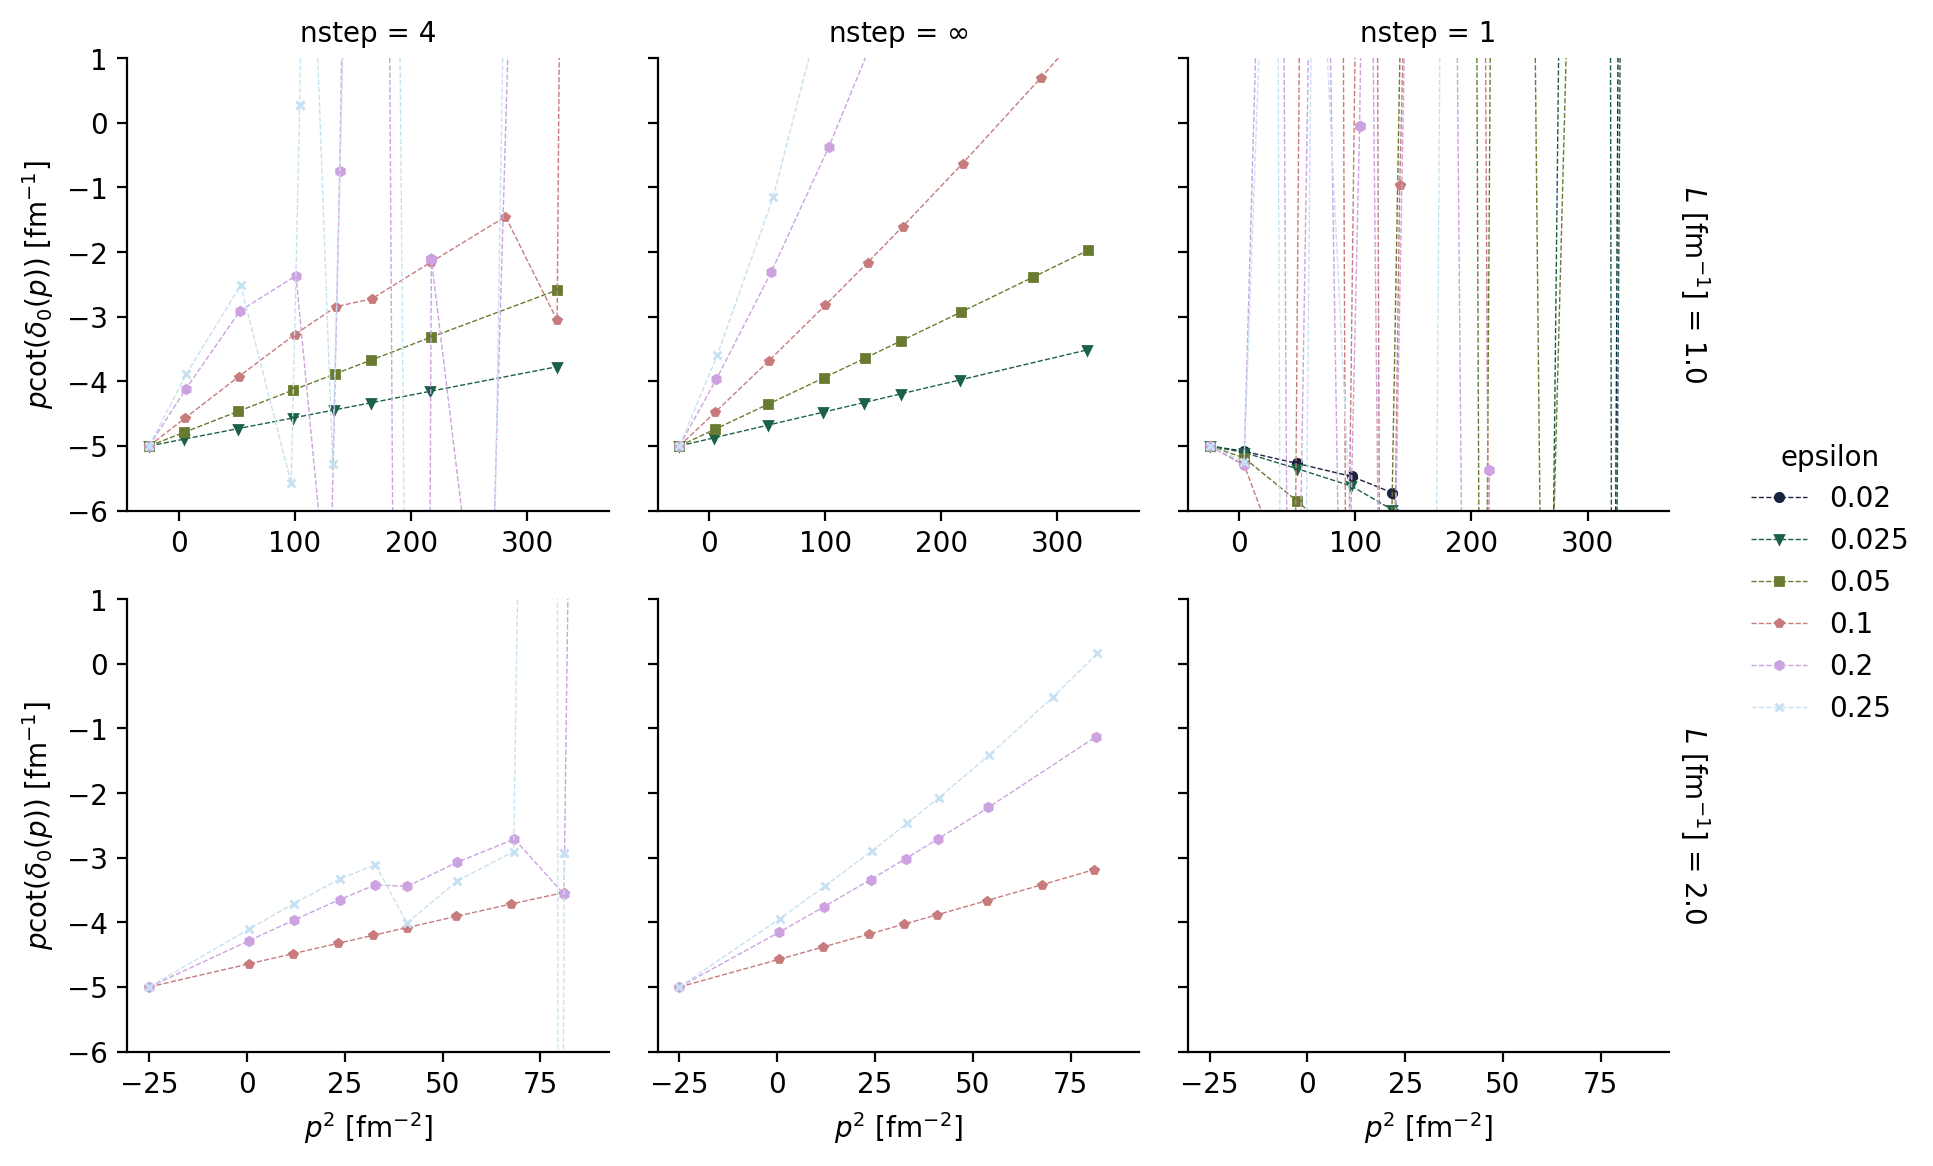

In [24]:
tf = df.query(query).sort_values("x")
for key, val in {
    "y": "$p \cot(\delta_0(p))$ [fm$^{-1}$]",
    "L": "$L$ [fm$^{-1}$]",
    "p2": "$p^2$ [fm$^{-2}$]",
}.items():
    tf[val] = tf[key]

grid = sns.FacetGrid(
    data=tf,
    col=col,
    hue=hue,
    row=row,
    sharex="row",
    sharey=True,
    legend_out=True,
    hue_kws={"marker": markers},
    palette="cubehelix",
    margin_titles=True,
    col_order=col_order
)

grid.map(plt.plot, x, y, ms=3, lw=0.5, ls="--", marker="s")

for ax in grid.axes.flatten():
    #ax.set_yscale("log")
    ax.set_ylim(-6, 1)

grid.fig.set_dpi(200)
grid.add_legend(frameon=False)

plt.show()


# Devel

In [61]:
DB_NAME = "db-contact-fv-c-fitted-parity-a-inv.sqlite"

df_c = read_table(os.path.join(DATA, DB_NAME), dispersion_zeta=False, round_digits=1)
df_d = read_table(os.path.join(DATA, DB_NAME.replace("fv-c", "fv-d")), dispersion_zeta=True, round_digits=1)
df_cd = read_table(os.path.join(DATA, DB_NAME), dispersion_zeta=True, round_digits=1)

df_c["type"] = "Regular Lüscher"
df_d["type"] = "Dispersion Lüscher"
df_cd["type"] = "RL fit, DL ERE"

df = df_c.append(df_d, ignore_index=True)
df = df.append(df_cd, ignore_index=True)


In [62]:
df.head()

,n1d,epsilon,nstep,mass,E,nlevel,date,type,L,E [MeV],p2,x,y
0,10,0.1,4,4.758,-5.352262,0,2019-06-20 01:56:00.819816,Regular Lüscher,1.0,-1056.145732,-25.466061,-0.645063,-5.000000
1,10,0.1,4,4.758,1.071784,1,2019-06-20 01:56:00.822161,Regular Lüscher,1.0,211.491931,5.099549,0.129173,-4.571709
2,10,0.1,4,4.758,10.803597,4,2019-06-20 01:56:00.827396,Regular Lüscher,1.0,2131.841407,51.403515,1.302066,-3.929139
3,10,0.1,4,4.758,20.937660,10,2019-06-20 01:56:00.837700,Regular Lüscher,1.0,4131.565627,99.621386,2.523439,-3.278211
4,10,0.1,4,4.758,28.474852,14,2019-06-20 01:56:00.849471,Regular Lüscher,1.0,5618.857105,135.483345,3.431833,-2.843693


In [63]:
row = "$L$ [fm$^{-1}$]"
hue = "epsilon"
col = "type"
x = "$p^2$ [fm$^{-2}$]"
y = "$p \cot(\delta_0(p))$ [fm$^{-1}$]"

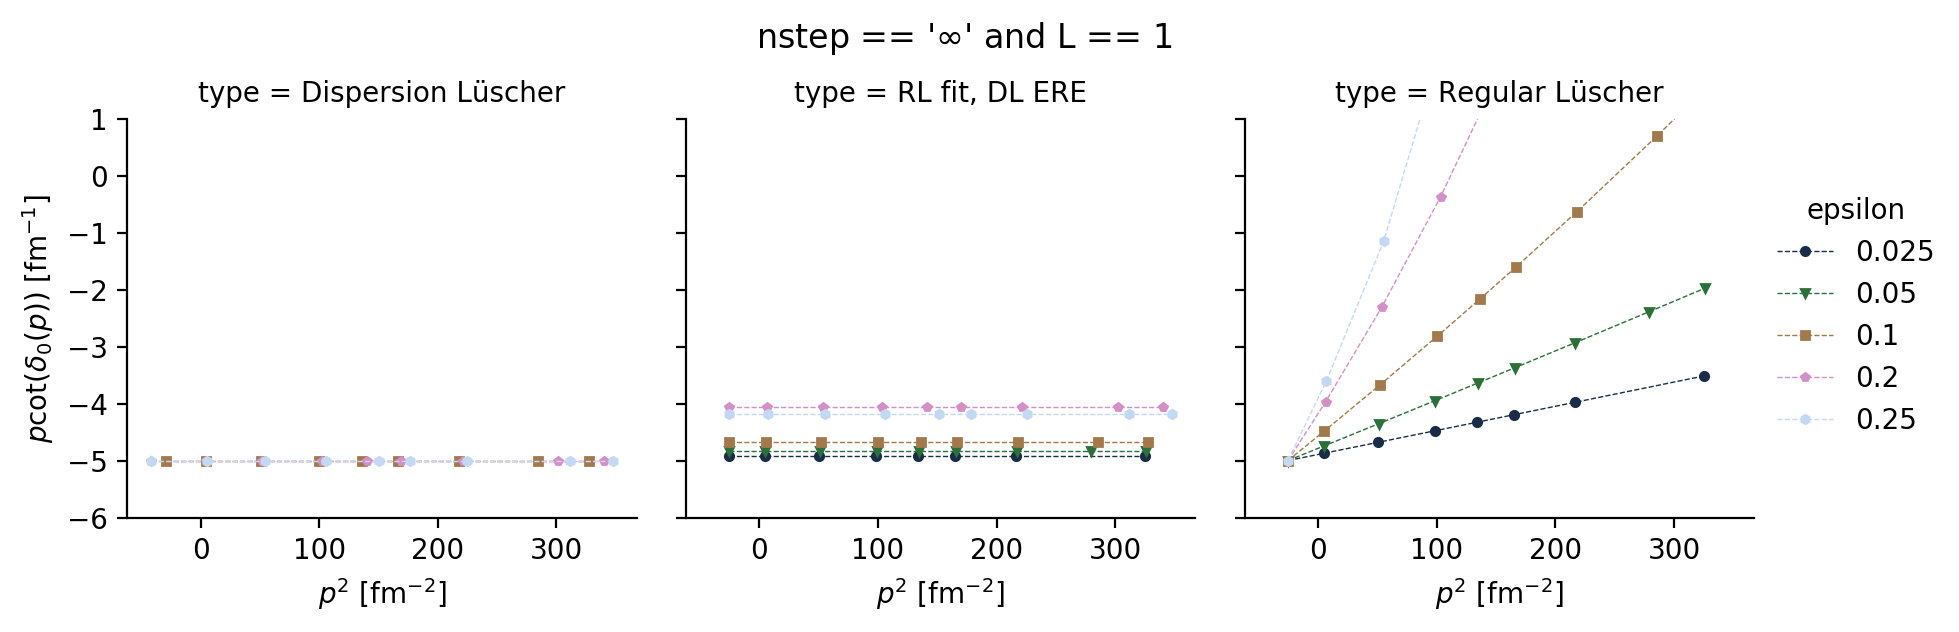

In [66]:
query = "nstep == '$\\infty$' and L == 1"

tf = df.query(query).sort_values("x")
for key, val in {
    "y": "$p \cot(\delta_0(p))$ [fm$^{-1}$]",
    "L": "$L$ [fm$^{-1}$]",
    "p2": "$p^2$ [fm$^{-2}$]",
}.items():
    tf[val] = tf[key]

grid = sns.FacetGrid(
    data=tf,
    col=col,
    hue=hue,
    #row=row,
    sharex="row",
    sharey=True,
    legend_out=True,
    hue_kws={"marker": markers},
    palette="cubehelix",
    margin_titles=False,
    row_order=df["type"].unique()
)

grid.map(plt.plot, x, y, ms=3, lw=0.5, ls="--", marker="s")

for ax in grid.axes.flatten():
    #ax.set_yscale("log")
    ax.set_ylim(-6, 1)

grid.fig.suptitle(query, y=1.05)
    
grid.fig.set_dpi(200)
grid.add_legend(frameon=False)

plt.show()



In [68]:
grid.fig.savefig("figs/contact-finte-scattering-comparison.jpg", bbox_inches="tight")

In [69]:
!open .